<a href="https://colab.research.google.com/github/Wizako-01/diabetes-ml-predictor/blob/main/TL_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras scikit-learn pandas numpy matplotlib seaborn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aminumusa/nigeria-chest-x-ray-dataset")

print("Path to dataset files:", path)

100%|██████████| 241M/241M [00:11<00:00, 21.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aminumusa/nigeria-chest-x-ray-dataset/versions/1


In [26]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the dataset to your Drive (this may take a few minutes)
!cp -r /root/.cache/kagglehub/datasets/aminumusa/nigeria-chest-x-ray-dataset/versions/1 "/content/drive/MyDrive/Nigeria_Xray_Project"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
^C


In [27]:
# Create a shortcut named 'my_data' in the visible file area
!ln -s /root/.cache/kagglehub/datasets/aminumusa/nigeria-chest-x-ray-dataset/versions/1 /content/my_data

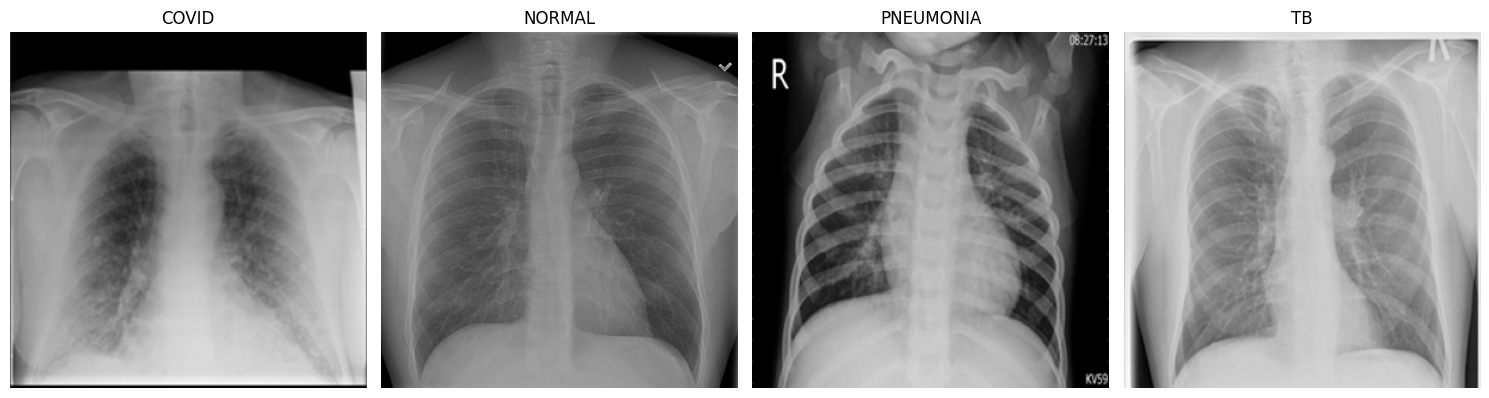

In [28]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the path based on your file sidebar discovery
train_path = "/content/my_data/my_dataset/train_folder"
categories = ['COVID', 'NORMAL', 'PNEUMONIA', 'TB']

plt.figure(figsize=(15, 5))

for i, category in enumerate(categories):
    folder_path = os.path.join(train_path, category)

    # Get the first image file in the folder
    img_name = os.listdir(folder_path)[0]
    img_path = os.path.join(folder_path, img_name)

    # Load and plot
    img = Image.open(img_path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{category}")
    plt.axis('off')

plt.tight_layout()

# SAVE THE FIGURE
plt.savefig('chest_xray_comparison.png', dpi=300)

plt.show()

In [29]:
!pip install split-folders

import splitfolders

# Input folder (your current train folder)
input_folder = "/content/my_data/my_dataset/train_folder"

# Output folder (where the new split will live)
output_folder = "/content/dataset_final"

# Split: Train (80%), Validation (20%)
# We don't need 'test' here because you already have a separate test_folder
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 2000 files [00:00, 4445.19 files/s]


In [30]:
import os

train_dir = "/content/my_data/my_dataset/train_folder"
classes = ['COVID', 'NORMAL', 'PNEUMONIA', 'TB']

print("--- Class Distribution in Training Folder ---")
for cls in classes:
    path = os.path.join(train_dir, cls)
    count = len(os.listdir(path))
    print(f"{cls}: {count} images")

--- Class Distribution in Training Folder ---
COVID: 500 images
NORMAL: 500 images
PNEUMONIA: 500 images
TB: 500 images


In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. THE WRAPPER (To allow different transforms for Train and Val) ---
class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

# --- 2. DEFINE THE TWO TYPES OF TRANSFORMS ---
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. LOAD AND STRATIFY SPLIT ---
train_dir = "/content/my_data/my_dataset/train_folder"
raw_dataset = datasets.ImageFolder(root=train_dir)

train_idx, val_idx = train_test_split(
    np.arange(len(raw_dataset)),
    test_size=0.2,
    stratify=raw_dataset.targets, # Keeps the 4 classes equal
    random_state=42
)

# --- 4. CREATE FINAL DATASETS AND LOADERS ---
train_data = ApplyTransform(Subset(raw_dataset, train_idx), transform=train_transforms)
val_data = ApplyTransform(Subset(raw_dataset, val_idx), transform=val_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# --- 5. PRINT RESULTS ---
print(f"Data Ready!")
print(f"Training images: {len(train_data)}")
print(f"Validation images: {len(val_data)}")
print(f"Classes: {raw_dataset.classes}")

Data Ready!
Training images: 1600
Validation images: 400
Classes: ['COVID', 'NORMAL', 'PNEUMONIA', 'TB']


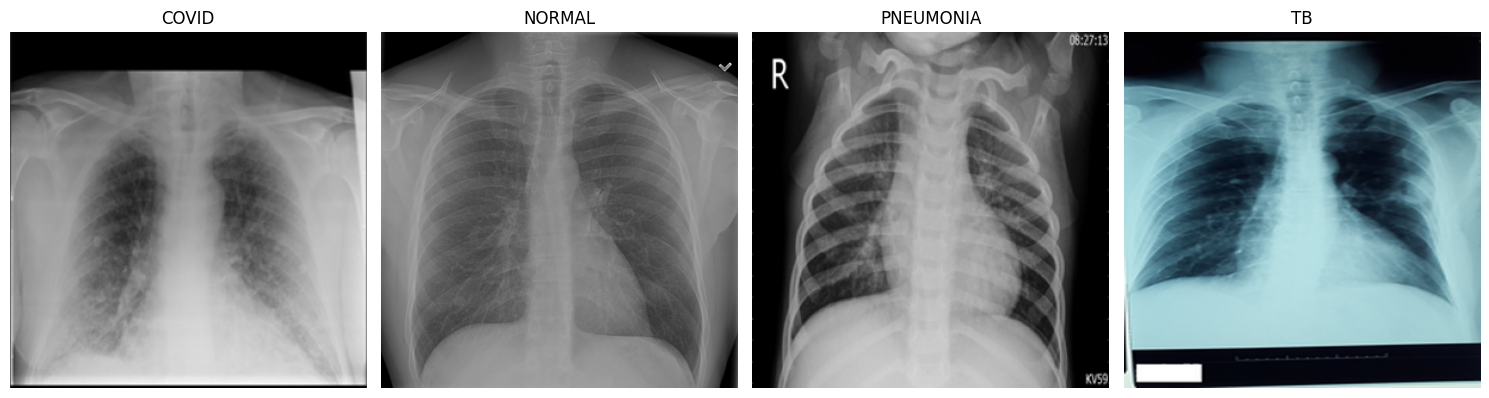

In [32]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the path based on your file sidebar discovery
train_path = "/content/dataset_final/train"
categories = ['COVID', 'NORMAL', 'PNEUMONIA', 'TB']

plt.figure(figsize=(15, 5))

for i, category in enumerate(categories):
    folder_path = os.path.join(train_path, category)

    # Get the first image file in the folder
    img_name = os.listdir(folder_path)[0]
    img_path = os.path.join(folder_path, img_name)

    # Load and plot
    img = Image.open(img_path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{category}")
    plt.axis('off')

plt.tight_layout()

# SAVE THE FIGURE
plt.savefig('chest_xray_comparison.png', dpi=300)

plt.show()

## **RESNET-50**

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]



 Stage 1: Warming up the Head...
Epoch 1/10 | Train Loss: 0.8871 Acc: 0.6388 | Val Loss: 0.5189 Acc: 0.8200
Epoch 2/10 | Train Loss: 0.5395 Acc: 0.8025 | Val Loss: 0.3573 Acc: 0.8650
Epoch 3/10 | Train Loss: 0.4697 Acc: 0.8269 | Val Loss: 0.3370 Acc: 0.8825
Epoch 4/10 | Train Loss: 0.4331 Acc: 0.8450 | Val Loss: 0.3402 Acc: 0.8775
Epoch 5/10 | Train Loss: 0.3745 Acc: 0.8656 | Val Loss: 0.3398 Acc: 0.8675
Epoch 6/10 | Train Loss: 0.3937 Acc: 0.8550 | Val Loss: 0.3168 Acc: 0.8600
Epoch 7/10 | Train Loss: 0.3624 Acc: 0.8712 | Val Loss: 0.2917 Acc: 0.8975
Epoch 8/10 | Train Loss: 0.3777 Acc: 0.8563 | Val Loss: 0.2809 Acc: 0.8925
Epoch 9/10 | Train Loss: 0.3207 Acc: 0.8850 | Val Loss: 0.3024 Acc: 0.8850
Epoch 10/10 | Train Loss: 0.3190 Acc: 0.8862 | Val Loss: 0.2781 Acc: 0.8875


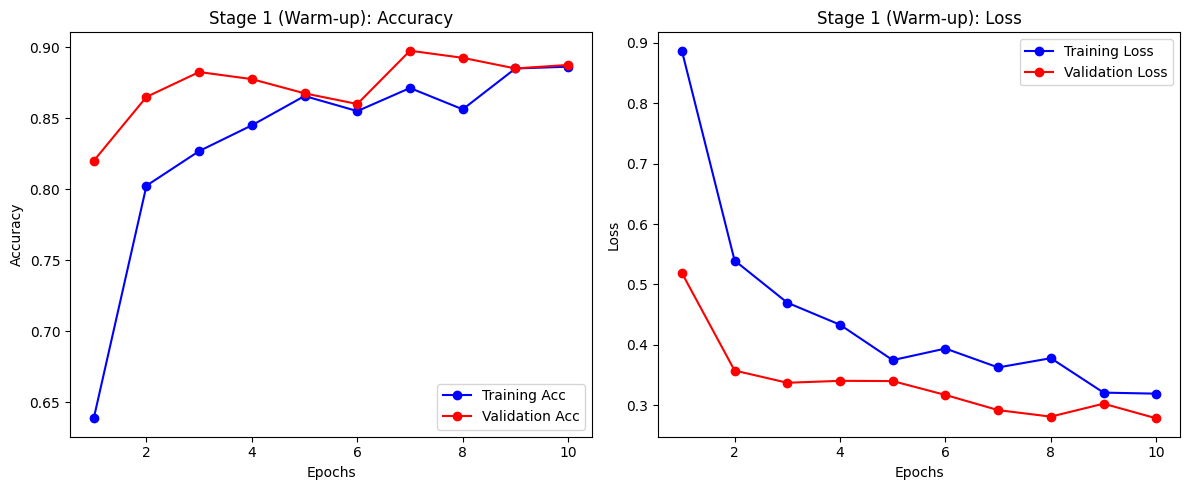


 Stage 2: Unfreezing Backbone for Fine-tuning...
Epoch 1/10 | Train Loss: 0.2538 Acc: 0.9131 | Val Loss: 0.1746 Acc: 0.9500
Epoch 2/10 | Train Loss: 0.1723 Acc: 0.9444 | Val Loss: 0.1458 Acc: 0.9500
Epoch 3/10 | Train Loss: 0.1243 Acc: 0.9606 | Val Loss: 0.1306 Acc: 0.9575
Epoch 4/10 | Train Loss: 0.1011 Acc: 0.9694 | Val Loss: 0.1124 Acc: 0.9550
Epoch 5/10 | Train Loss: 0.0786 Acc: 0.9738 | Val Loss: 0.1190 Acc: 0.9625
Epoch 6/10 | Train Loss: 0.0633 Acc: 0.9819 | Val Loss: 0.1031 Acc: 0.9700
Epoch 7/10 | Train Loss: 0.0498 Acc: 0.9850 | Val Loss: 0.0796 Acc: 0.9725
Epoch 8/10 | Train Loss: 0.0311 Acc: 0.9919 | Val Loss: 0.0982 Acc: 0.9675
Epoch 9/10 | Train Loss: 0.0376 Acc: 0.9850 | Val Loss: 0.0818 Acc: 0.9725
Epoch 10/10 | Train Loss: 0.0261 Acc: 0.9950 | Val Loss: 0.0678 Acc: 0.9750


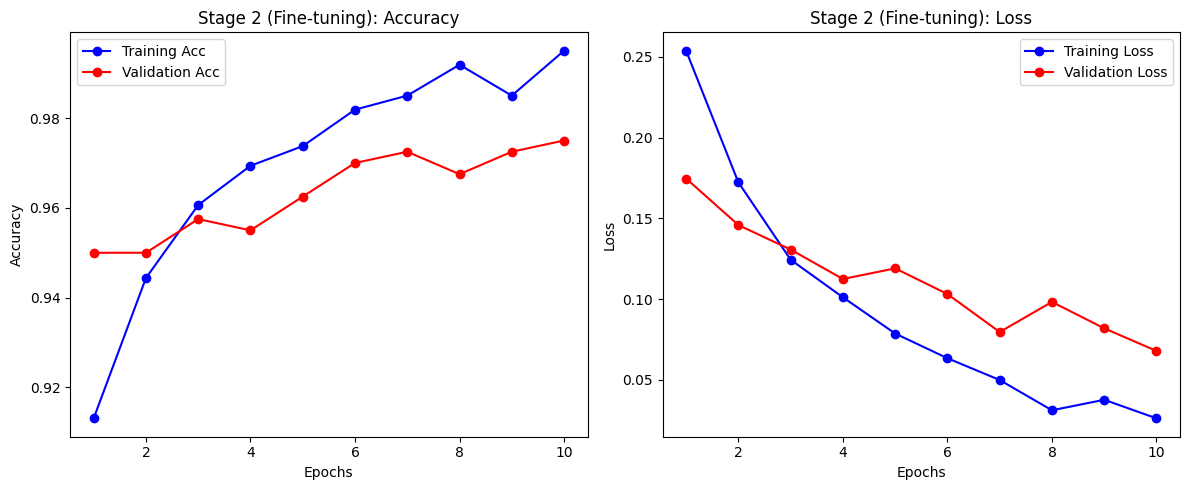

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
import matplotlib.pyplot as plt

# 0. Device Configuration (GPU Check)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

# 1. Model Setup
# Loading ResNet50 with Pre-trained ImageNet weights
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze backbone initially
for param in model.parameters():
    param.requires_grad = False

# Modify the head (Final Layers) for 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 4)
)
model = model.to(device)

# 2. Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 3. Training Function with Metrics History
def train_complex(model, criterion, optimizer, epochs, is_finetuning=False):
    early_stopper = EarlyStopping(patience=3)
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Storage for plotting
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        # Calculate Averages
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)

        # Save to history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Save best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_wts = copy.deepcopy(model.state_dict())

        # Check Early Stopping
        early_stopper(epoch_val_loss)
        if early_stopper.early_stop:
            print(" Early stopping triggered.")
            break

    model.load_state_dict(best_wts)
    return model, history

# 4. Visualization Function
def plot_results(history, stage_name):
    epochs = range(1, len(history['train_acc']) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title(f'{stage_name}: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title(f'{stage_name}: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- EXECUTION ---

# STAGE 1: Warm-up
print("\n Stage 1: Warming up the Head...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model, stage1_history = train_complex(model, criterion, optimizer, epochs=10)
plot_results(stage1_history, "Stage 1 (Warm-up)")

# STAGE 2: Fine-Tuning
print("\n Stage 2: Unfreezing Backbone for Fine-tuning...")
for param in model.parameters():
    param.requires_grad = True

# Lower learning rate for fine-tuning to protect pre-trained weights
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model, stage2_history = train_complex(model, criterion, optimizer, epochs=10, is_finetuning=True)
plot_results(stage2_history, "Stage 2 (Fine-tuning)")

# Optional: Save the final model
# torch.save(model.state_dict(), 'resnet50_finetuned.pth')

✅ Overall Test Accuracy: 93.17%

--- Detailed Performance Metrics ---
    Class  Sensitivity  Specificity  Precision  F1-score
    COVID       0.9800       0.9289     0.8212    0.8936
   NORMAL       0.8267       0.9933     0.9764    0.8953
PNEUMONIA       0.9933       0.9889     0.9675    0.9803
       TB       0.9267       0.9978     0.9929    0.9586


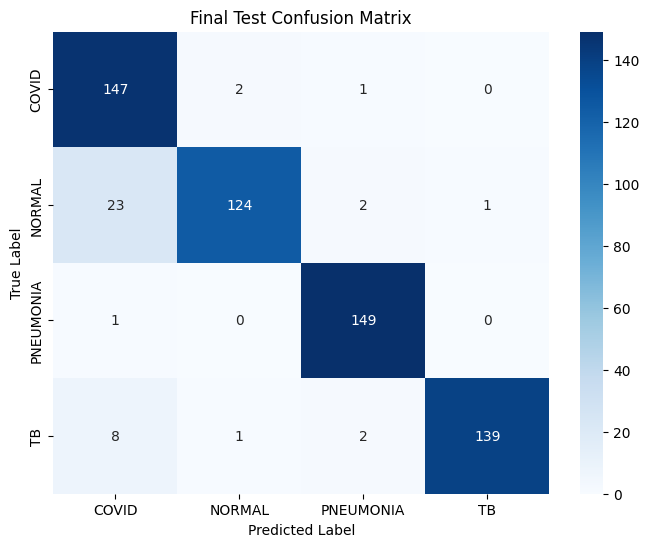

In [35]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. SETUP TEST DATA
test_dir = '/content/my_data/my_dataset/test_folder'
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. DEFINE EVALUATION FUNCTION
def evaluate_final_results(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    # Run Inference
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Metrics
    cm = confusion_matrix(all_labels, all_preds)
    classes = test_dataset.classes
    metrics = []

    for i in range(len(classes)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        metrics.append({
            "Class": classes[i],
            "Sensitivity": round(sensitivity, 4),
            "Specificity": round(specificity, 4),
            "Precision": round(precision, 4),
            "F1-score": round(f1, 4)
        })

    # Overall Accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
    print(f"✅ Overall Test Accuracy: {accuracy*100:.2f}%")

    # Display Metrics Table
    metrics_df = pd.DataFrame(metrics)
    print("\n--- Detailed Performance Metrics ---")
    print(metrics_df.to_string(index=False))

    # Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Final Test Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return metrics_df

# 3. EXECUTE TEST
# This makes the results appear!
final_stats = evaluate_final_results(model, test_loader)

In [36]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=d50e5368e669283465cf0bc6b9adb0fc24abe85cada0fd2f5a9644a6f62f05ba
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


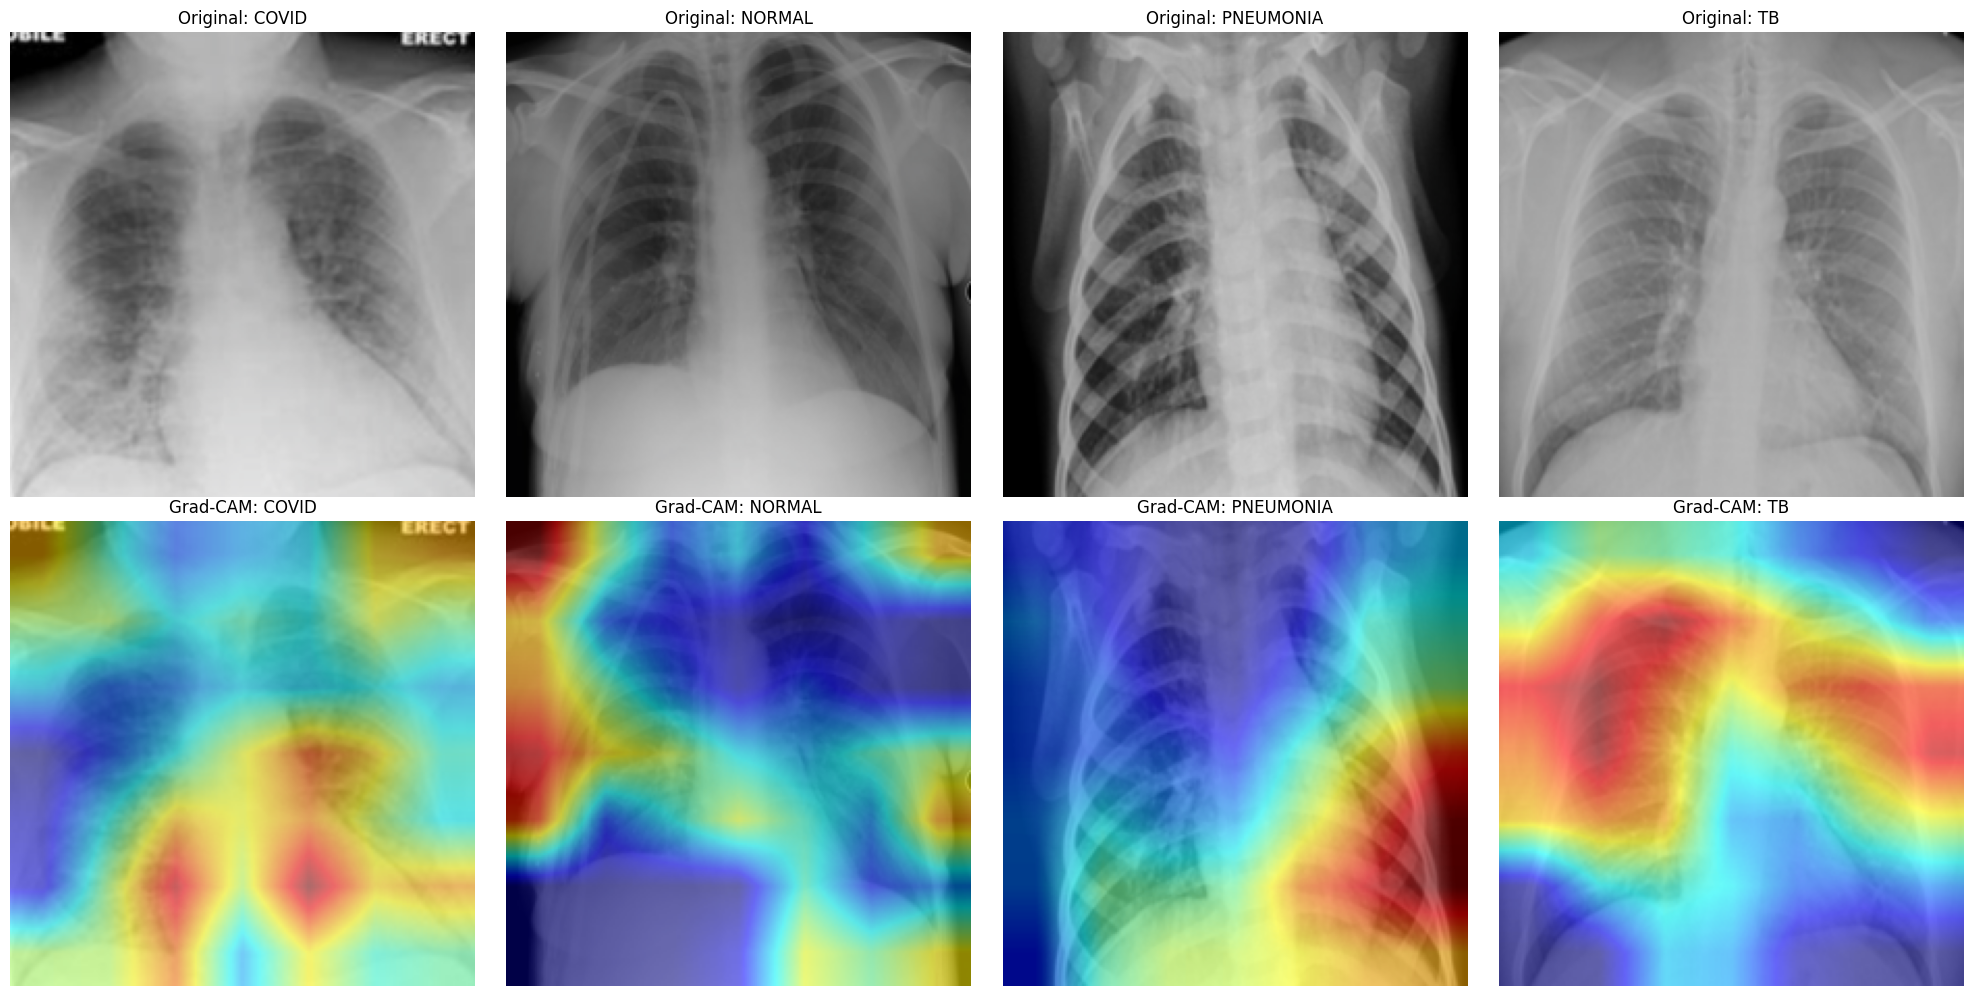

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_one_of_each_class(dataset, model):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    classes = dataset.classes
    found_indices = {}

    # Search for the first index of each class
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label not in found_indices:
            found_indices[label] = i
        if len(found_indices) == len(classes):
            break

    # Setup Grad-CAM
    target_layers = [model.resnet.layer4[-1]] if hasattr(model, 'resnet') else [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    plt.figure(figsize=(20, 10))

    for i, class_idx in enumerate(sorted(found_indices.keys())):
        idx = found_indices[class_idx]
        input_tensor, label = dataset[idx]
        input_batch = input_tensor.unsqueeze(0).to(device)

        # Heatmap generation
        grayscale_cam = cam(input_tensor=input_batch, targets=None)[0, :]

        # Un-normalize
        img = input_tensor.permute(1, 2, 0).numpy()
        img = np.array([0.229, 0.224, 0.225]) * img + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        vis = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        # Plotting the 4 classes in a row
        plt.subplot(2, len(classes), i + 1)
        plt.imshow(img)
        plt.title(f"Original: {classes[label]}")
        plt.axis('off')

        plt.subplot(2, len(classes), i + 1 + len(classes))
        plt.imshow(vis)
        plt.title(f"Grad-CAM: {classes[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# RUN THIS
get_one_of_each_class(test_dataset, model)

In [38]:

torch.save(model.state_dict(), 'resnet50_covid_model.pth')
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [39]:
# Run this to download the model to your PC right now
from google.colab import files
files.download('resnet50_covid_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Macro-average ROC-AUC: 0.9977


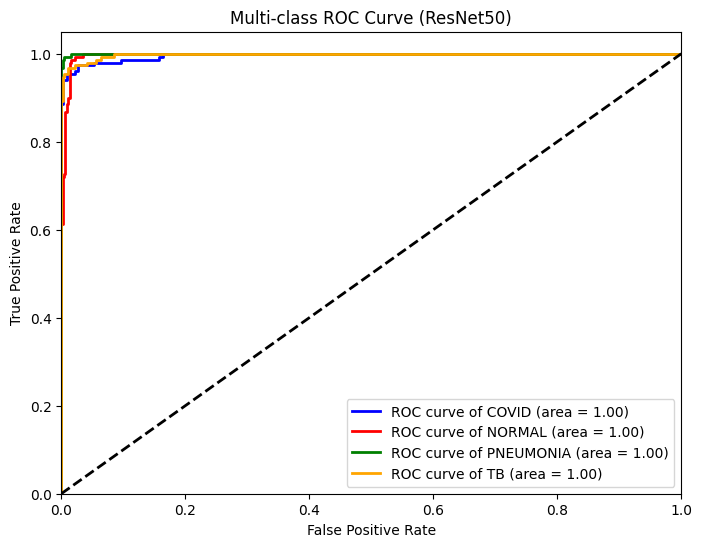

In [40]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

def calculate_roc_auc(model, loader, num_classes=4):
    model.eval()
    all_probs = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get probabilities using Softmax
            probs = F.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # 1. Calculate Macro-average ROC-AUC
    # 'ovr' stands for One-vs-Rest, which is standard for multi-class
    macro_roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

    print(f"\n Macro-average ROC-AUC: {macro_roc_auc:.4f}")

    # 2. Plotting ROC Curves for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    classes = test_dataset.classes

    for i in range(num_classes):
        # Create binary labels for the current class
        binary_labels = (all_labels == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(binary_labels, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve (ResNet50)')
    plt.legend(loc="lower right")
    plt.show()

    return macro_roc_auc

# EXECUTE
macro_auc = calculate_roc_auc(model, test_loader)

SECTION FOR DENSENET


In [ ]:
# 1. New Model Definition (DenseNet121)
model_densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model_densenet.parameters():
    param.requires_grad = False

# Modify the head for DenseNet121 (input is 1024)
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)
model_densenet = model_densenet.to(device)

# Define loss (can reuse the 'criterion' variable from before)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 48.8MB/s]



🔥 Stage 1: Warming up DenseNet...
Epoch 1/10 | Train Loss: 0.7833 Acc: 0.7031 | Val Loss: 0.4563 Acc: 0.8450
Epoch 2/10 | Train Loss: 0.4484 Acc: 0.8319 | Val Loss: 0.3185 Acc: 0.8950
Epoch 3/10 | Train Loss: 0.3737 Acc: 0.8581 | Val Loss: 0.2800 Acc: 0.9025
Epoch 4/10 | Train Loss: 0.3696 Acc: 0.8613 | Val Loss: 0.2642 Acc: 0.9100
Epoch 5/10 | Train Loss: 0.3275 Acc: 0.8856 | Val Loss: 0.3046 Acc: 0.8975
Epoch 6/10 | Train Loss: 0.3407 Acc: 0.8731 | Val Loss: 0.2696 Acc: 0.9100
Epoch 7/10 | Train Loss: 0.3079 Acc: 0.8875 | Val Loss: 0.2614 Acc: 0.9225
Epoch 8/10 | Train Loss: 0.2593 Acc: 0.9069 | Val Loss: 0.2051 Acc: 0.9350
Epoch 9/10 | Train Loss: 0.2649 Acc: 0.9000 | Val Loss: 0.2433 Acc: 0.9025
Epoch 10/10 | Train Loss: 0.3059 Acc: 0.8831 | Val Loss: 0.2015 Acc: 0.9300


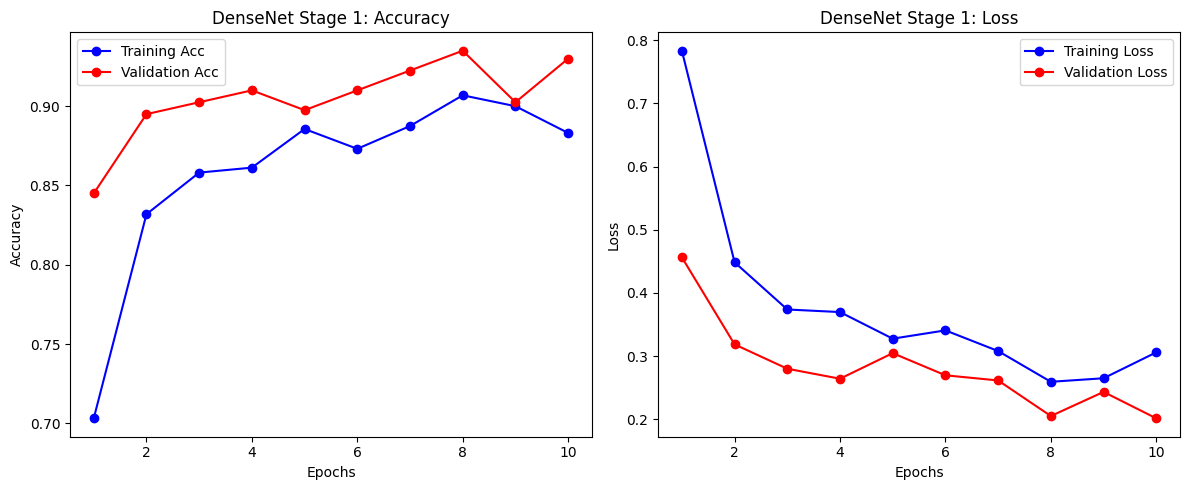

In [ ]:
print("\n Stage 1: Warming up DenseNet...")
# We only optimize the classifier parameters
optimizer_dn = optim.Adam(model_densenet.classifier.parameters(), lr=0.001)

# Use the function you already defined earlier
model_densenet, dn_stage1_history = train_complex(model_densenet, criterion, optimizer_dn, epochs=10)

plot_results(dn_stage1_history, "DenseNet Stage 1")


🧬 Stage 2: Fine-tuning DenseNet...
Epoch 1/10 | Train Loss: 0.2363 Acc: 0.9094 | Val Loss: 0.1873 Acc: 0.9475
Epoch 2/10 | Train Loss: 0.1651 Acc: 0.9475 | Val Loss: 0.1481 Acc: 0.9500
Epoch 3/10 | Train Loss: 0.1498 Acc: 0.9469 | Val Loss: 0.1251 Acc: 0.9650
Epoch 4/10 | Train Loss: 0.1255 Acc: 0.9531 | Val Loss: 0.1113 Acc: 0.9700
Epoch 5/10 | Train Loss: 0.1024 Acc: 0.9625 | Val Loss: 0.1064 Acc: 0.9700
Epoch 6/10 | Train Loss: 0.0860 Acc: 0.9756 | Val Loss: 0.1029 Acc: 0.9725
Epoch 7/10 | Train Loss: 0.0792 Acc: 0.9700 | Val Loss: 0.0890 Acc: 0.9725
Epoch 8/10 | Train Loss: 0.0729 Acc: 0.9750 | Val Loss: 0.0988 Acc: 0.9750
Epoch 9/10 | Train Loss: 0.0624 Acc: 0.9788 | Val Loss: 0.0860 Acc: 0.9750
Epoch 10/10 | Train Loss: 0.0578 Acc: 0.9813 | Val Loss: 0.0890 Acc: 0.9750


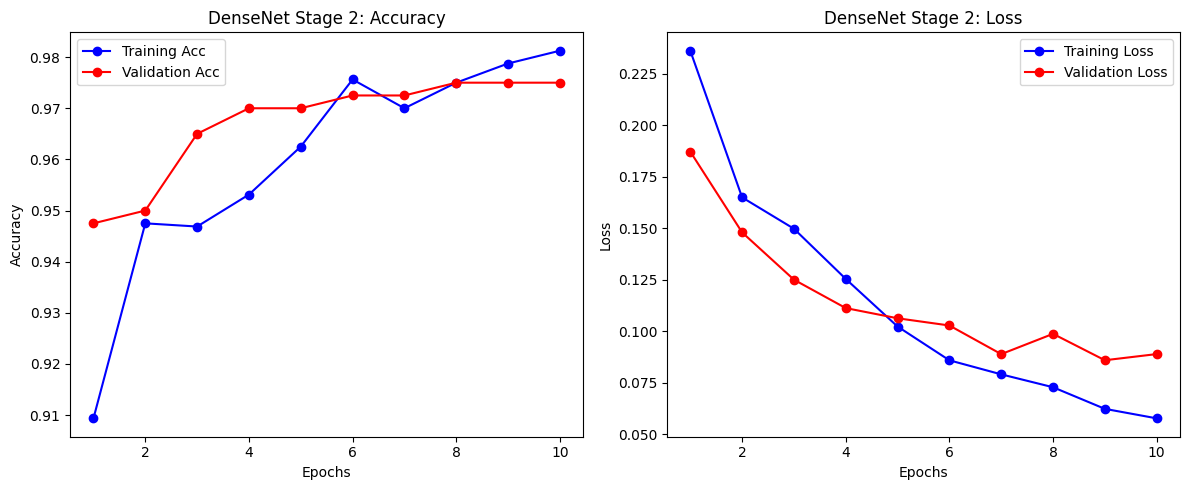

In [ ]:
print("\n Stage 2: Fine-tuning DenseNet...")
for param in model_densenet.parameters():
    param.requires_grad = True

# Lower learning rate for the whole model
optimizer_dn_ft = optim.Adam(model_densenet.parameters(), lr=1e-5)

model_densenet, dn_stage2_history = train_complex(model_densenet, criterion, optimizer_dn_ft, epochs=10)

plot_results(dn_stage2_history, "DenseNet Stage 2")

✅ Overall Test Accuracy: 92.67%

--- Detailed Performance Metrics ---
    Class  Sensitivity  Specificity  Precision  F1-score
    COVID       0.9467       0.9422     0.8452    0.8931
   NORMAL       0.8867       0.9756     0.9236    0.9048
PNEUMONIA       1.0000       0.9867     0.9615    0.9804
       TB       0.8733       0.9978     0.9924    0.9291


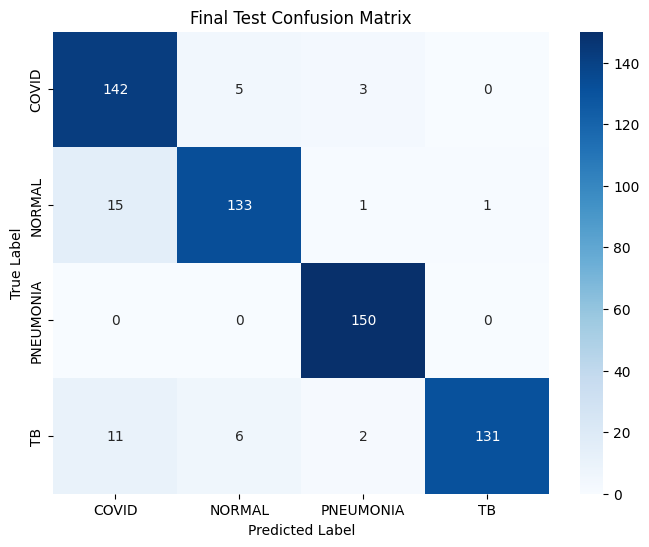


🏆 DenseNet121 Macro-Average F1-score: 0.9269


In [ ]:
# 3. EXECUTE TEST FOR DENSENET
# We pass 'model_densenet' (the one with 97.5% val accuracy) into your function
final_stats_densenet = evaluate_final_results(model_densenet, test_loader)

# Optional: Print the average F1-score for your paper's summary
avg_f1 = final_stats_densenet['F1-score'].mean()
print(f"\n DenseNet121 Macro-Average F1-score: {avg_f1:.4f}")

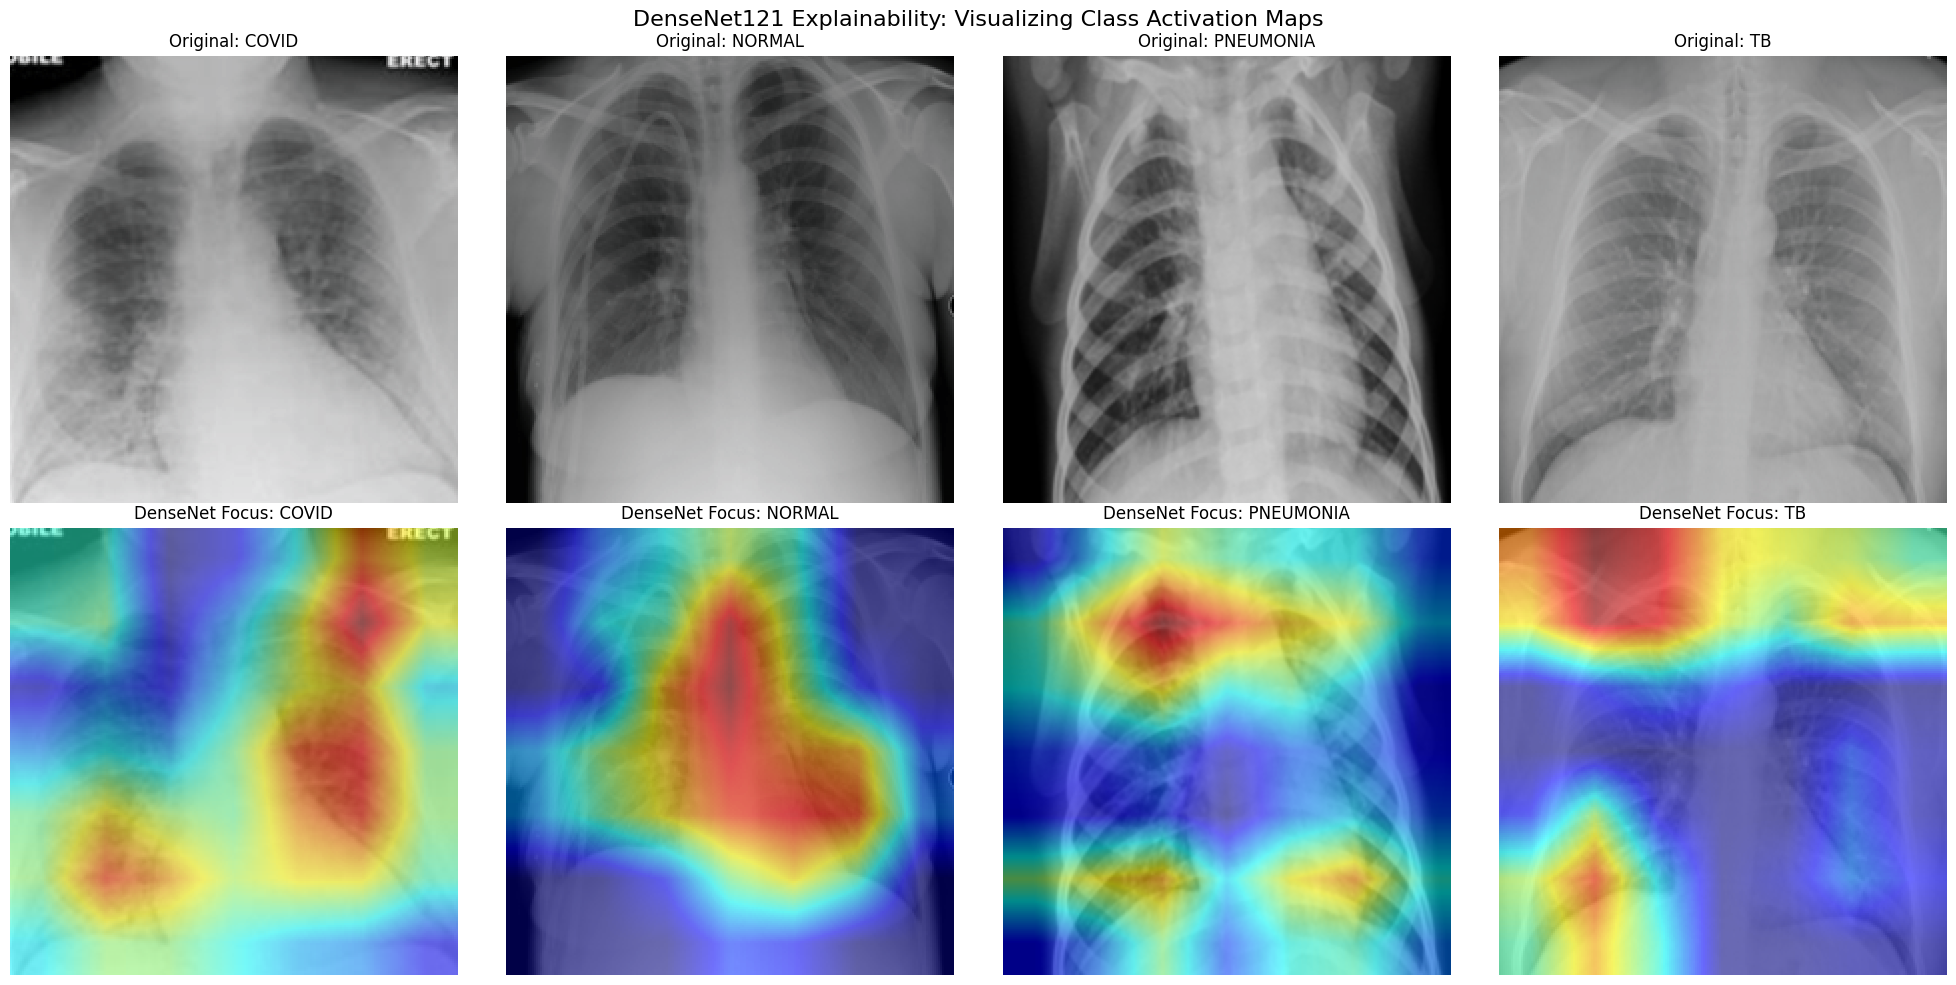

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_one_of_each_class_densenet(dataset, model):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    classes = dataset.classes
    found_indices = {}

    # 1. Search for the first index of each class
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label not in found_indices:
            found_indices[label] = i
        if len(found_indices) == len(classes):
            break

    # 2. Setup Grad-CAM for DenseNet
    # In DenseNet, the last feature map is at model.features[-1]
    target_layers = [model.features[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    plt.figure(figsize=(20, 10))

    for i, class_idx in enumerate(sorted(found_indices.keys())):
        idx = found_indices[class_idx]
        input_tensor, label = dataset[idx]
        input_batch = input_tensor.unsqueeze(0).to(device)

        # 3. Heatmap generation
        # Note: 'targets=None' defaults to the highest scoring category (the prediction)
        grayscale_cam = cam(input_tensor=input_batch, targets=None)[0, :]

        # 4. Un-normalize image for display
        img = input_tensor.permute(1, 2, 0).numpy()
        # Using ImageNet normalization constants
        img = np.array([0.229, 0.224, 0.225]) * img + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # 5. Overlay heatmap on original image
        vis = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        # Plotting the Original vs Grad-CAM
        plt.subplot(2, len(classes), i + 1)
        plt.imshow(img)
        plt.title(f"Original: {classes[label]}")
        plt.axis('off')

        plt.subplot(2, len(classes), i + 1 + len(classes))
        plt.imshow(vis)
        plt.title(f"DenseNet Focus: {classes[label]}")
        plt.axis('off')

    plt.suptitle("DenseNet121 Explainability: Visualizing Class Activation Maps", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
# Pass your DenseNet model here
get_one_of_each_class_densenet(test_dataset, model_densenet)


⭐ DenseNet121 Macro-average ROC-AUC: 0.9940


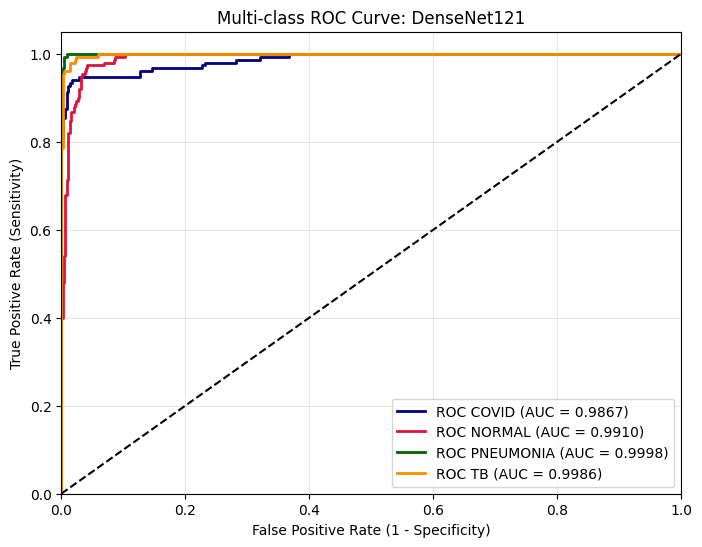

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

def calculate_roc_auc_densenet(model, loader, num_classes=4):
    model.eval()
    all_probs = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Convert raw outputs (logits) to probabilities
            probs = F.softmax(outputs, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Calculate Macro-average ROC-AUC using One-vs-Rest (OvR)
    macro_roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')

    print(f"\n DenseNet121 Macro-average ROC-AUC: {macro_roc_auc:.4f}")

    # Plotting setup
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    classes = test_dataset.classes

    plt.figure(figsize=(8, 6))
    colors = cycle(['navy', 'crimson', 'darkgreen', 'darkorange'])

    for i, color in zip(range(num_classes), colors):
        binary_labels = (all_labels == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(binary_labels, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC {classes[i]} (AUC = {roc_auc[i]:.4f})')

    # Plot the random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Multi-class ROC Curve: DenseNet121')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    return macro_roc_auc

# --- EXECUTION ---
macro_auc_dn = calculate_roc_auc_densenet(model_densenet, test_loader)

**EFFICIENTNET-BO**

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# 1. Load EfficientNet-B0
model_eff = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# 2. Freeze backbone
for param in model_eff.parameters():
    param.requires_grad = False

# 3. Replace the classifier
# EfficientNet-B0 output features are 1280
num_ftrs = model_eff.classifier[1].in_features
model_eff.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, 4)
)

model_eff = model_eff.to(device)
print("✅ EfficientNet-B0 initialized.")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 169MB/s]

✅ EfficientNet-B0 initialized.



🔥 Stage 1: Warming up EfficientNet Head...
Epoch 1/10 | Train Loss: 0.5628 Acc: 0.7950 | Val Loss: 0.2200 Acc: 0.9250
Epoch 2/10 | Train Loss: 0.3008 Acc: 0.8969 | Val Loss: 0.2643 Acc: 0.9100
Epoch 3/10 | Train Loss: 0.3144 Acc: 0.8906 | Val Loss: 0.2242 Acc: 0.9400
Epoch 4/10 | Train Loss: 0.2620 Acc: 0.9069 | Val Loss: 0.1780 Acc: 0.9400
Epoch 5/10 | Train Loss: 0.2031 Acc: 0.9294 | Val Loss: 0.1663 Acc: 0.9400
Epoch 6/10 | Train Loss: 0.1907 Acc: 0.9337 | Val Loss: 0.2062 Acc: 0.9325
Epoch 7/10 | Train Loss: 0.2203 Acc: 0.9231 | Val Loss: 0.1951 Acc: 0.9275
Epoch 8/10 | Train Loss: 0.1737 Acc: 0.9394 | Val Loss: 0.1782 Acc: 0.9375
🛑 Early stopping triggered.

🧬 Stage 2: Fine-tuning EfficientNet...
Epoch 1/10 | Train Loss: 0.2128 Acc: 0.9263 | Val Loss: 0.2073 Acc: 0.9275
Epoch 2/10 | Train Loss: 0.1936 Acc: 0.9300 | Val Loss: 0.1758 Acc: 0.9450
Epoch 3/10 | Train Loss: 0.1698 Acc: 0.9400 | Val Loss: 0.1613 Acc: 0.9525
Epoch 4/10 | Train Loss: 0.1422 Acc: 0.9563 | Val Loss: 0.1594 

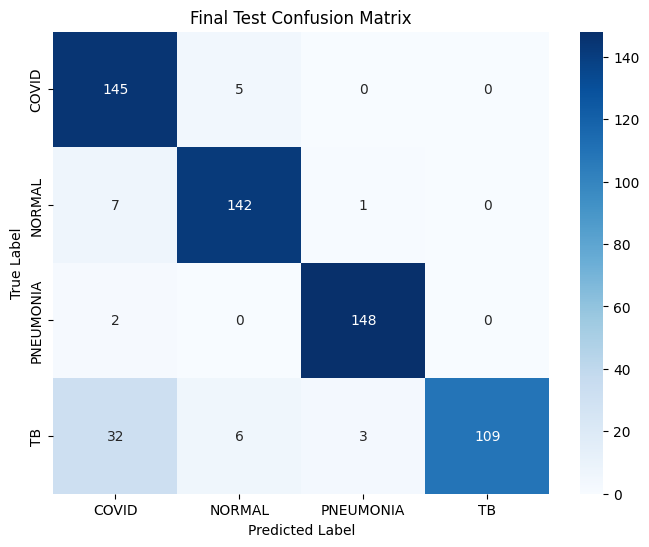


⭐ DenseNet121 Macro-average ROC-AUC: 0.9941


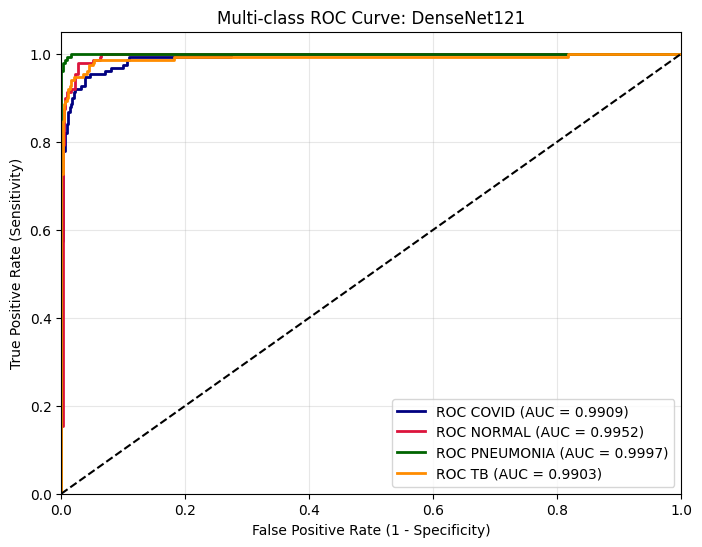

In [ ]:
# --- STAGE 1: WARM-UP ---
print("\n Stage 1: Warming up EfficientNet Head...")
optimizer_eff = optim.Adam(model_eff.classifier.parameters(), lr=0.001)
model_eff, eff_history1 = train_complex(model_eff, criterion, optimizer_eff, epochs=10)

# --- STAGE 2: FINE-TUNING ---
print("\n Stage 2: Fine-tuning EfficientNet...")
for param in model_eff.parameters():
    param.requires_grad = True

optimizer_eff_ft = optim.Adam(model_eff.parameters(), lr=1e-5)
model_eff, eff_history2 = train_complex(model_eff, criterion, optimizer_eff_ft, epochs=10)

# --- FINAL EVALUATION ---
final_stats_eff = evaluate_final_results(model_eff, test_loader)
macro_auc_eff = calculate_roc_auc_densenet(model_eff, test_loader) # Uses same logic

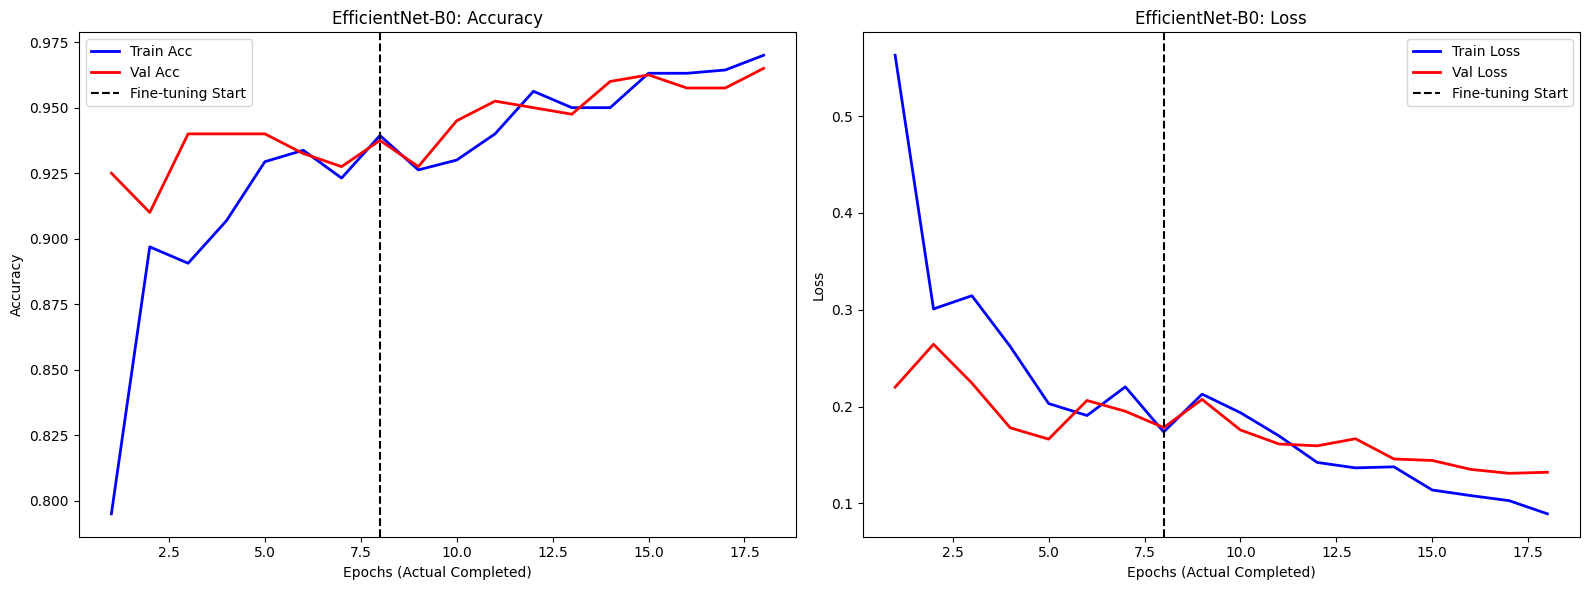

In [ ]:
import matplotlib.pyplot as plt

def plot_final_clean_eff(h1, h2):
    # 1. Combine histories
    total_train_loss = h1['train_loss'] + h2['train_loss']
    total_val_loss = h1['val_loss'] + h2['val_loss']
    total_train_acc = h1['train_acc'] + h2['train_acc']
    total_val_acc = h1['val_acc'] + h2['val_acc']

    # 2. KEY FIX: Create the x-axis based on the ACTUAL length of data
    # This prevents the "straight line" at the end
    actual_epochs = range(1, len(total_train_loss) + 1)

    # Identify where Stage 1 ended
    stage1_length = len(h1['train_loss'])

    plt.figure(figsize=(16, 6))

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(actual_epochs, total_train_acc, 'b-', label='Train Acc', linewidth=2)
    plt.plot(actual_epochs, total_val_acc, 'r-', label='Val Acc', linewidth=2)
    plt.axvline(x=stage1_length, color='black', linestyle='--', label='Fine-tuning Start')
    plt.title('EfficientNet-B0: Accuracy')
    plt.xlabel('Epochs (Actual Completed)')
    plt.ylabel('Accuracy')
    plt.legend()

    # --- Loss Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(actual_epochs, total_train_loss, 'b-', label='Train Loss', linewidth=2)
    plt.plot(actual_epochs, total_val_loss, 'r-', label='Val Loss', linewidth=2)
    plt.axvline(x=stage1_length, color='black', linestyle='--', label='Fine-tuning Start')
    plt.title('EfficientNet-B0: Loss')
    plt.xlabel('Epochs (Actual Completed)')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# EXECUTE
plot_final_clean_eff(eff_history1, eff_history2)

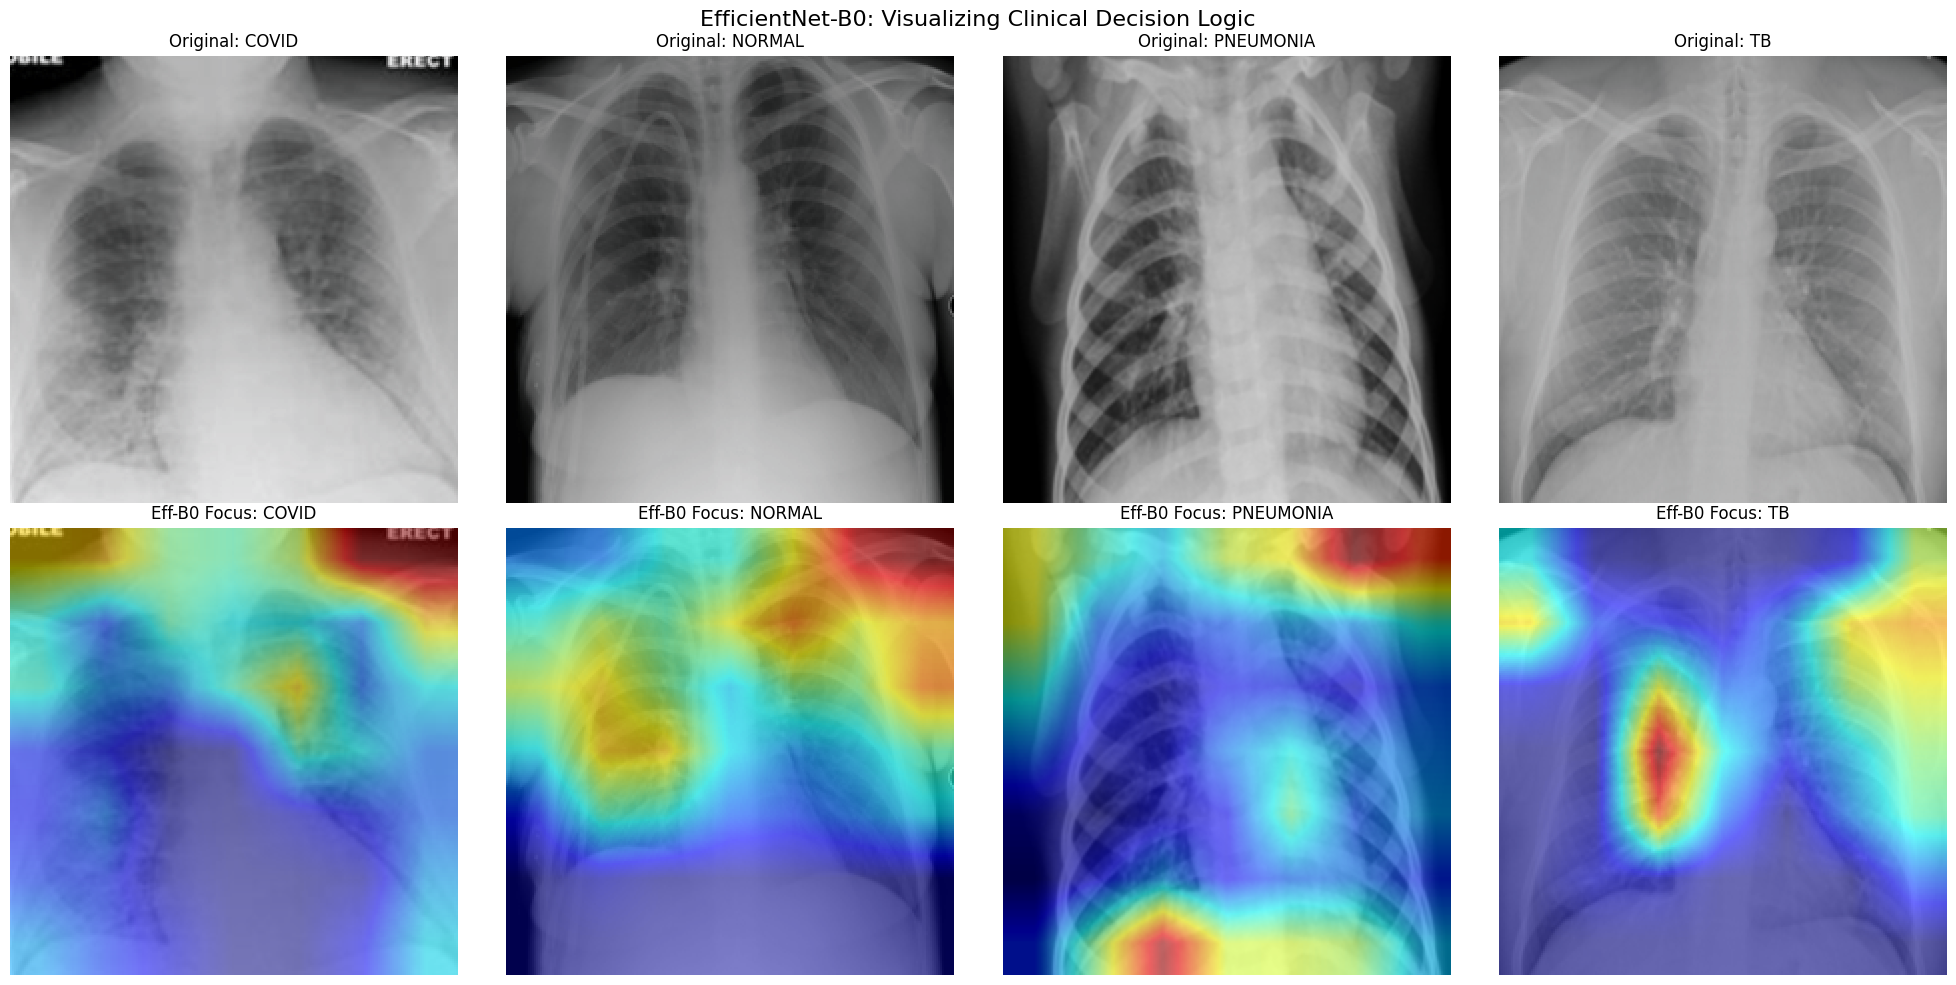

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_one_of_each_class_eff(dataset, model):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    classes = dataset.classes
    found_indices = {}

    # 1. Identify the first image of each class in the test set
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label not in found_indices:
            found_indices[label] = i
        if len(found_indices) == len(classes):
            break

    # 2. Setup Grad-CAM for EfficientNet
    # EfficientNet's final feature map is model.features[-1]
    target_layers = [model.features[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    plt.figure(figsize=(20, 10))

    for i, class_idx in enumerate(sorted(found_indices.keys())):
        idx = found_indices[class_idx]
        input_tensor, label = dataset[idx]
        input_batch = input_tensor.unsqueeze(0).to(device)

        # 3. Generate the heatmap (targets=None uses the predicted class)
        grayscale_cam = cam(input_tensor=input_batch, targets=None)[0, :]

        # 4. Un-normalize image for visualization
        img = input_tensor.permute(1, 2, 0).numpy()
        img = np.array([0.485, 0.456, 0.406]) + img * np.array([0.229, 0.224, 0.225])
        img = np.clip(img, 0, 1)

        # 5. Create the RGB overlay
        vis = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        # 6. Plotting
        # Original Image
        plt.subplot(2, len(classes), i + 1)
        plt.imshow(img)
        plt.title(f"Original: {classes[label]}")
        plt.axis('off')

        # Heatmap Overlay
        plt.subplot(2, len(classes), i + 1 + len(classes))
        plt.imshow(vis)
        plt.title(f"Eff-B0 Focus: {classes[label]}")
        plt.axis('off')

    plt.suptitle("EfficientNet-B0: Visualizing Clinical Decision Logic", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
get_one_of_each_class_eff(test_dataset, model_eff)

In [ ]:
!pip install thop

In [ ]:
# Install thop if you haven't: !pip install thop
from thop import profile

def check_computational_cost(model, name):
    model.eval()
    dummy_input = torch.randn(1, 3, 224, 224).to(device)

    # 1. Calculate FLOPs (Computational Complexity)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)

    # 2. Calculate Inference Speed (Latency)
    import time
    start_time = time.time()
    for _ in range(100):
        _ = model(dummy_input)
    latency = (time.time() - start_time) / 100 * 1000 # in milliseconds

    print(f" --- {name} ---")
    print(f"Parameters: {params/1e6:.2f} Million")
    print(f"FLOPs (MACs): {macs/1e9:.2f} GigaMACs")
    print(f"Inference Latency: {latency:.2f} ms per image")
    print("-" * 20)

# Run for all three
check_computational_cost(model, "ResNet50")
check_computational_cost(model_densenet, "DenseNet121")
check_computational_cost(model_eff, "EfficientNet-B0")

📊 --- ResNet50 ---
Parameters: 24.03 Million
FLOPs (MACs): 4.13 GigaMACs
Inference Latency: 9.57 ms per image
--------------------
📊 --- DenseNet121 ---
Parameters: 7.48 Million
FLOPs (MACs): 2.90 GigaMACs
Inference Latency: 30.30 ms per image
--------------------
📊 --- EfficientNet-B0 ---
Parameters: 4.67 Million
FLOPs (MACs): 0.41 GigaMACs
Inference Latency: 25.29 ms per image
--------------------


## **SAVE MODELS**

In [ ]:


# Define file names
densenet_path = "densenet121_covid_final.pth"
efficientnet_path = "efficientnet_b0_covid_final.pth"

# Save DenseNet
torch.save(model_densenet.state_dict(), densenet_path)
print(f" DenseNet121 weights saved to: {densenet_path}")

# Save EfficientNet
torch.save(model_eff.state_dict(), efficientnet_path)
print(f" EfficientNet-B0 weights saved to: {efficientnet_path}")

✅ DenseNet121 weights saved to: densenet121_covid_final.pth
✅ EfficientNet-B0 weights saved to: efficientnet_b0_covid_final.pth


In [ ]:
from google.colab import files

# Download the DenseNet weights
files.download('densenet121_covid_final.pth')

# Download the EfficientNet weights
files.download('efficientnet_b0_covid_final.pth')

# Optional: Download the ResNet weights if you saved those too
# files.download('resnet50_covid_final.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

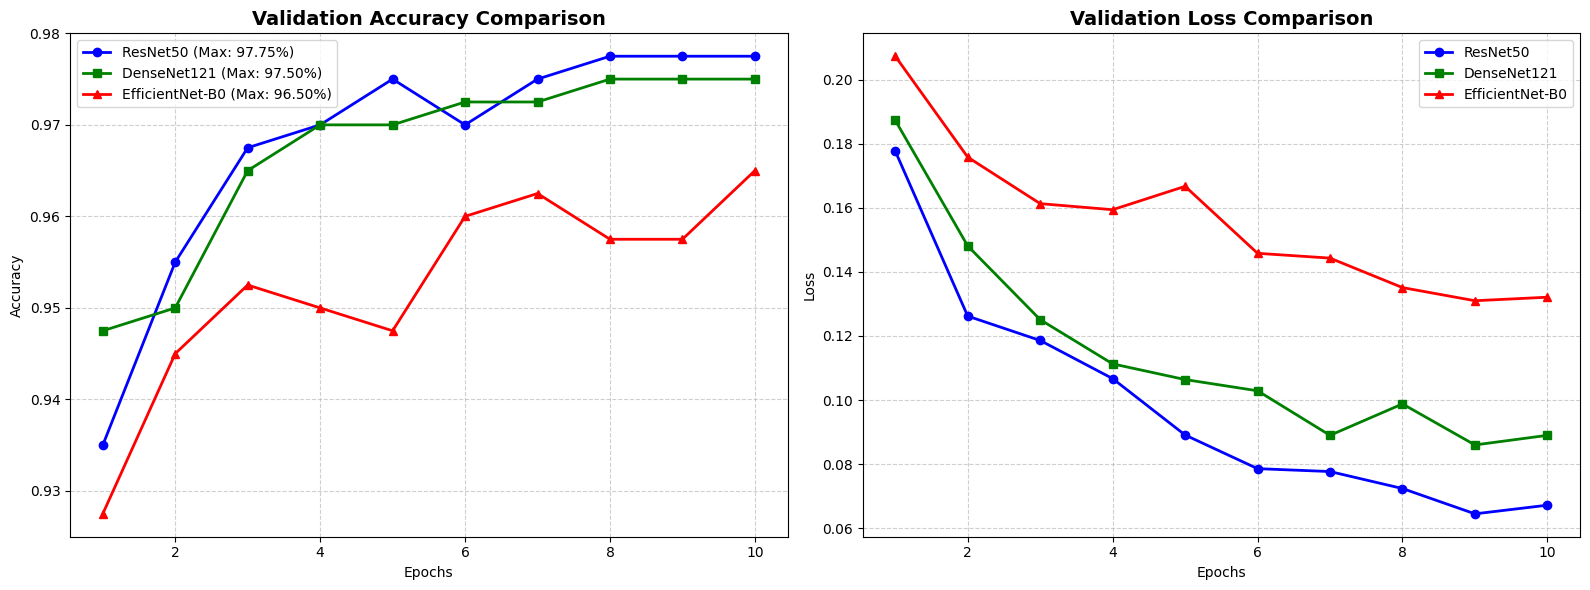

In [ ]:
import matplotlib.pyplot as plt

# Epochs 1-10
epochs = range(1, 11)

# 1. ResNet50 Data
resnet_acc = [0.9350, 0.9550, 0.9675, 0.9700, 0.9750, 0.9700, 0.9750, 0.9775, 0.9775, 0.9775]
resnet_loss = [0.1777, 0.1262, 0.1186, 0.1067, 0.0891, 0.0786, 0.0777, 0.0724, 0.0645, 0.0672]

# 2. DenseNet121 Data
densenet_acc = [0.9475, 0.9500, 0.9650, 0.9700, 0.9700, 0.9725, 0.9725, 0.9750, 0.9750, 0.9750]
densenet_loss = [0.1873, 0.1481, 0.1251, 0.1113, 0.1064, 0.1029, 0.0890, 0.0988, 0.0860, 0.0890]

# 3. EfficientNet-B0 Data
effnet_acc = [0.9275, 0.9450, 0.9525, 0.9500, 0.9475, 0.9600, 0.9625, 0.9575, 0.9575, 0.9650]
effnet_loss = [0.2073, 0.1758, 0.1613, 0.1594, 0.1667, 0.1458, 0.1443, 0.1351, 0.1310, 0.1321]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy Plot
ax1.plot(epochs, resnet_acc, 'b-o', label='ResNet50 (Max: 97.75%)', linewidth=2)
ax1.plot(epochs, densenet_acc, 'g-s', label='DenseNet121 (Max: 97.50%)', linewidth=2)
ax1.plot(epochs, effnet_acc, 'r-^', label='EfficientNet-B0 (Max: 96.50%)', linewidth=2)
ax1.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# Loss Plot
ax2.plot(epochs, resnet_loss, 'b-o', label='ResNet50', linewidth=2)
ax2.plot(epochs, densenet_loss, 'g-s', label='DenseNet121', linewidth=2)
ax2.plot(epochs, effnet_loss, 'r-^', label='EfficientNet-B0', linewidth=2)
ax2.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()

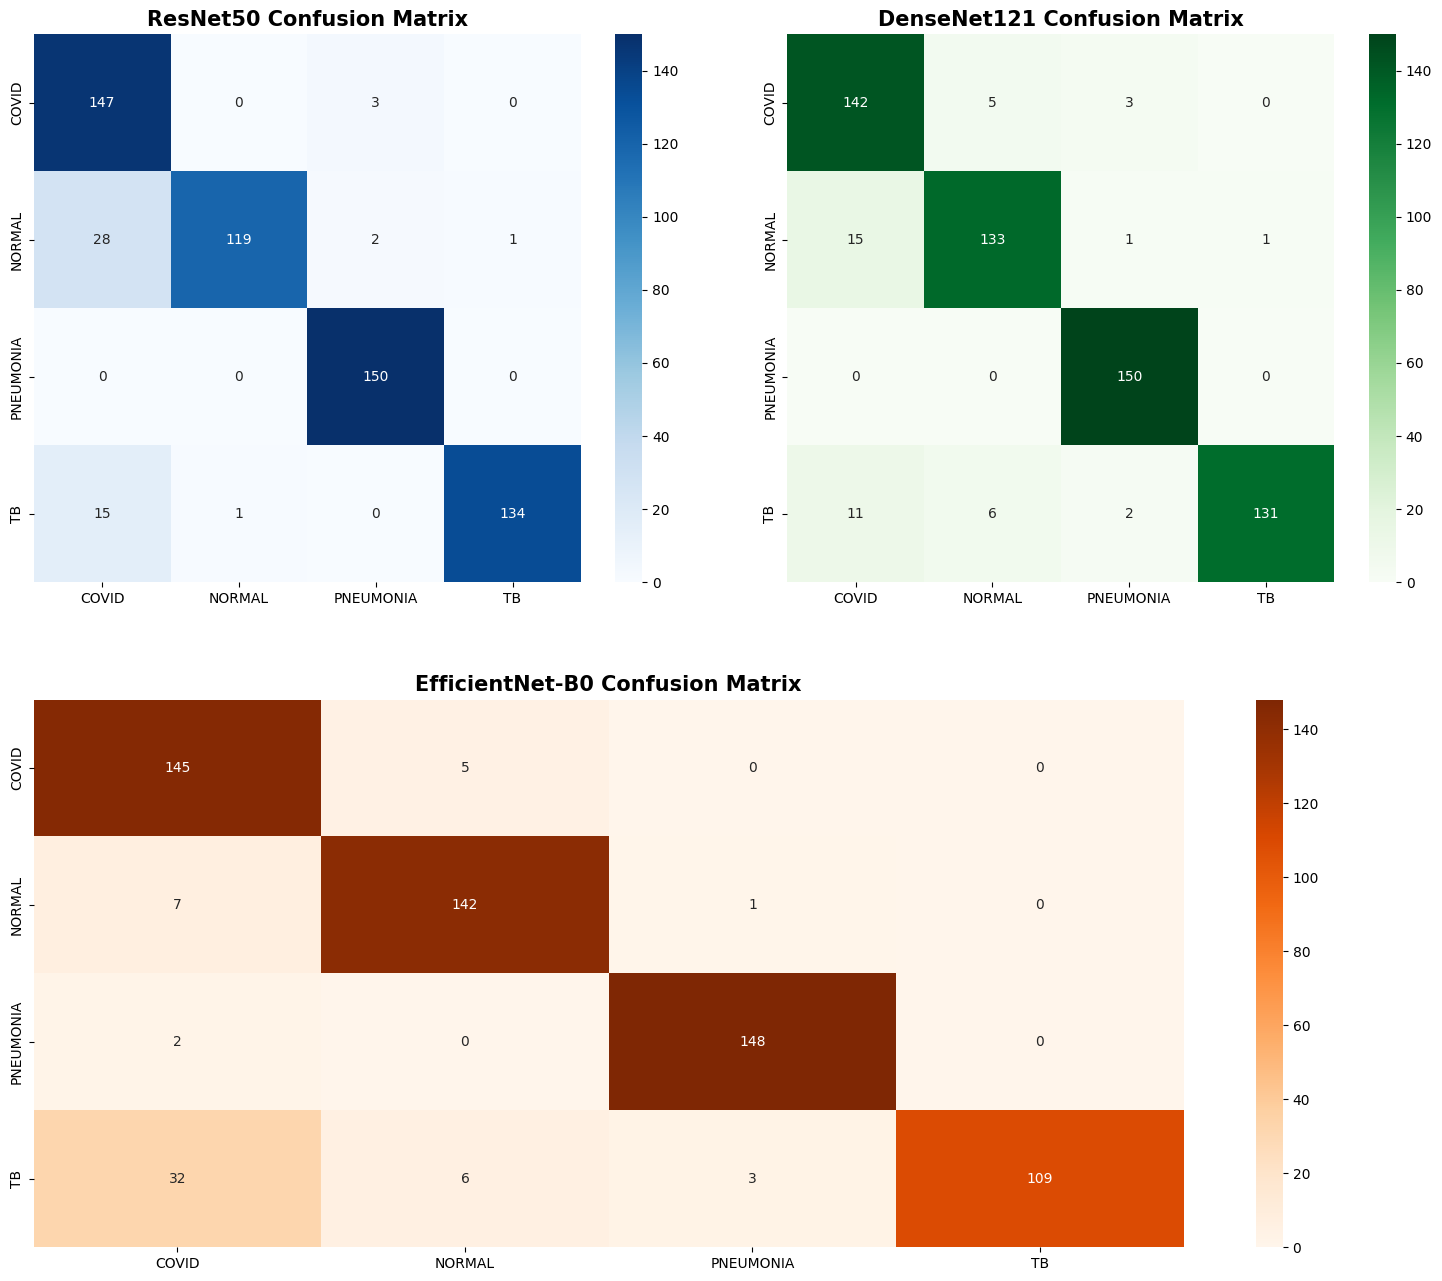

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Class labels
classes = ['COVID', 'NORMAL', 'PNEUMONIA', 'TB']

# EXACT DATA FROM YOUR UPLOADED IMAGES
resnet_cm = np.array([
    [147, 0, 3, 0],   # COVID
    [28, 119, 2, 1],  # NORMAL
    [0, 0, 150, 0],   # PNEUMONIA
    [15, 1, 0, 134]   # TB
])

densenet_cm = np.array([
    [142, 5, 3, 0],   # COVID
    [15, 133, 1, 1],  # NORMAL
    [0, 0, 150, 0],   # PNEUMONIA
    [11, 6, 2, 131]   # TB
])

effnet_cm = np.array([
    [145, 5, 0, 0],   # COVID
    [7, 142, 1, 0],   # NORMAL
    [2, 0, 148, 0],   # PNEUMONIA
    [32, 6, 3, 109]   # TB
])

# Create figure with a 2x2 grid to allow the bottom one to be centered
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(2, 2)

# Top Left: ResNet50
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(resnet_cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=classes, yticklabels=classes)
ax1.set_title('ResNet50 Confusion Matrix', fontsize=15, fontweight='bold')

# Top Right: DenseNet121
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(densenet_cm, annot=True, fmt='d', cmap='Greens', ax=ax2, xticklabels=classes, yticklabels=classes)
ax2.set_title('DenseNet121 Confusion Matrix', fontsize=15, fontweight='bold')

# Bottom Center: EfficientNet-B0
# We use a subplot that spans both columns or just center it manually
ax3 = fig.add_subplot(gs[1, :])
# Adjusting the position of the bottom plot so it doesn't stretch too wide
pos = ax3.get_position()
ax3.set_position([0.25, pos.y0, 0.5, pos.height])

sns.heatmap(effnet_cm, annot=True, fmt='d', cmap='Oranges', ax=ax3, xticklabels=classes, yticklabels=classes)
ax3.set_title('EfficientNet-B0 Confusion Matrix', fontsize=15, fontweight='bold')

plt.tight_layout(pad=5.0)
plt.show()

In [5]:
def load_model_safely(arch_type, path):
    try:
        # 1. Define Architecture
        if arch_type == 'resnet':
            m = models.resnet50()
            m.fc = nn.Sequential(nn.Linear(m.fc.in_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 4))
        elif arch_type == 'densenet':
            m = models.densenet121()
            m.classifier = nn.Sequential(nn.Linear(m.classifier.in_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 4))
        elif arch_type == 'efficientnet':
            m = models.efficientnet_b0()
            m.classifier[1] = nn.Sequential(nn.Linear(m.classifier[1].in_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 4))

        # 2. Load the state_dict
        state_dict = torch.load(path, map_location='cpu')

        # 3. Clean the state_dict (Remove profiling keys)
        # This removes anything ending in .total_ops or .total_params
        cleaned_state_dict = {k: v for k, v in state_dict.items() if "total_ops" not in k and "total_params" not in k}

        # 4. Load with strict=False
        m.load_state_dict(cleaned_state_dict, strict=False)
        m.to(device).eval()

        print(f" {arch_type} loaded successfully (ignored extra profiling keys).")
        return m
    except Exception as e:
        print(f" Failed to load {arch_type}: {e}")
        return None

# Now re-run your loading
model_res = load_model_safely('resnet', '/content/resnet50_covid_model (1).pth')
model_dense = load_model_safely('densenet', '/content/densenet121_covid_final (1).pth')
model_eff = load_model_safely('efficientnet', '/content/efficientnet_b0_covid_final (1).pth')

✅ resnet loaded successfully (ignored extra profiling keys).
✅ densenet loaded successfully (ignored extra profiling keys).
✅ efficientnet loaded successfully (ignored extra profiling keys).


In [44]:
from sklearn.metrics import brier_score_loss
import numpy as np

def calculate_ece(y_true, y_probs, n_bins=10):
    """
    Calculates Expected Calibration Error (ECE)
    y_true: true labels (0, 1, 2, 3)
    y_probs: probability for the predicted class
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    confidences = np.max(y_probs, axis=1)
    predictions = np.argmax(y_probs, axis=1)
    accuracies = (predictions == y_true)

    ece = 0
    for bin_lower, bin_upper in zip(bin_boundaries[:-1], bin_boundaries[1:]):
        # Determine items in this bin
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece

def get_calibration_report(name, y_true, y_probs):
    # For multiclass Brier, we use One-vs-Rest (OvR) approach
    # We binarize labels for the Brier calculation
    brier_scores = []
    for i in range(y_probs.shape[1]):
        y_bi = (y_true == i).astype(int)
        brier_scores.append(brier_score_loss(y_bi, y_probs[:, i]))

    avg_brier = np.mean(brier_scores)
    ece = calculate_ece(y_true, y_probs)

    print(f"--- Calibration: {name} ---")
    print(f"  Average Brier Score: {avg_brier:.4f} (Lower is better)")
    print(f"  Expected Calibration Error (ECE): {ece:.4f} (Lower is better)\n")
    return avg_brier, ece

In [45]:
import torch
import numpy as np

# Ensure your models are in eval mode and moved to the correct device
model_res.eval()
model_dense.eval()
model_eff.eval()

p_res_list, p_dense_list, p_eff_list, y_true_list = [], [], [], []

print(" Generating probabilities from Test Loader (this may take a minute)...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        # Get raw outputs and convert to probabilities via Softmax
        out_res = torch.softmax(model_res(inputs), dim=1)
        out_dense = torch.softmax(model_dense(inputs), dim=1)
        out_eff = torch.softmax(model_eff(inputs), dim=1)

        # Move to CPU and store
        p_res_list.append(out_res.cpu().numpy())
        p_dense_list.append(out_dense.cpu().numpy())
        p_eff_list.append(out_eff.cpu().numpy())
        y_true_list.append(labels.numpy())

# Flatten the lists into clean NumPy arrays
p_res = np.vstack(p_res_list)
p_dense = np.vstack(p_dense_list)
p_eff = np.vstack(p_eff_list)
y_true = np.concatenate(y_true_list)

print(f"Success! Variables defined. Test samples: {len(y_true)}")

 Generating probabilities from Test Loader (this may take a minute)...
Success! Variables defined. Test samples: 600


In [46]:
# Now run the reports
get_calibration_report("ResNet50", y_true, p_res)
get_calibration_report("DenseNet121", y_true, p_dense)
get_calibration_report("EfficientNet-B0", y_true, p_eff)

# Calculate Ensemble Calibration
p_ensemble = (p_res + p_dense + p_eff) / 3
get_calibration_report("Late Fusion Ensemble", y_true, p_ensemble)

--- Calibration: ResNet50 ---
  Average Brier Score: 0.0301 (Lower is better)
  Expected Calibration Error (ECE): 0.0311 (Lower is better)

--- Calibration: DenseNet121 ---
  Average Brier Score: 0.0271 (Lower is better)
  Expected Calibration Error (ECE): 0.0100 (Lower is better)

--- Calibration: EfficientNet-B0 ---
  Average Brier Score: 0.1866 (Lower is better)
  Expected Calibration Error (ECE): 0.0845 (Lower is better)

--- Calibration: Late Fusion Ensemble ---
  Average Brier Score: 0.0426 (Lower is better)
  Expected Calibration Error (ECE): 0.2417 (Lower is better)



(np.float64(0.04262468939598536), np.float64(0.24166814898451167))